In [1]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA

from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np


os.chdir('../raw_data')


In [3]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_ms2ds_embedding.pickle',
 'all_spec_embedding.pickle',
 'df_ALL_GNPS_15_12_2021_positive_annotated_embeddings_class.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_max3_embeddings.pickle',
 'df_classes_max5_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'lightning_logs',
 'max3_mol2vec_embedding.pickle',
 'max3_ms2ds_embedding.pickle',
 'max3_spec_embedding.pickle',
 'max5_mol2vec_embedding.pickle',
 'max5_ms2ds_embedding.pickle',
 'max5_spec_embedding.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'ms2ds_pred_euc',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',


#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [3]:
# load df with all info
path = './df_classes_unique_embeddings.pickle'
df_all = Files(path).load_pickle()#[:2000] #just a subset for scripting
df_all.shape

(20889, 8)

In [50]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.3, random_state=42)#, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
test_df, val_df = train_test_split(test_df, test_size=0.1, random_state=42)

#required for early stopage
val_df['set'] = 'val'
#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['ms2ds']]), np.array([x for x in test_df['ms2ds']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['ms2ds']]), np.array([x for x in val_df['mol2vec']])

In [54]:
# What does CCA dataset do????
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])

train_loader, val_loader = get_dataloaders(train_dataset, val_dataset, batch_size=128, num_workers=6,
                                              drop_last=False)
test_loader = get_dataloaders(test_dataset,batch_size=128, num_workers=6,
                                              drop_last=False)

In [55]:
#params
N = len(train_dataset)
latent_dims = 50
epochs = 100
#cca = CCA(latent_dims=latent_dims).fit((X, Y))

# define encoders
encoder_1 = architectures.Encoder(latent_dims=50, feature_size=v1_train.shape[1], layer_sizes=(128,))
                                     
encoder_2 = architectures.Encoder(latent_dims=50, feature_size=v2_train.shape[1], layer_sizes=(128,))

# define variant algorithmns
# 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.CCA,
        )

# 2. SDL
sdl = DCCA_SDL(latent_dims,
                N=N, encoders=[encoder_1, encoder_2],
                lam=1e-2, lr=1e-3)

# Define the trainer
trainer = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1,
        callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="val/corr")])# early stopage to reduce overfitting

# train
trainer.fit(dcca, train_loader,val_loader)

#transform the views to get z projections


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 77.2 K
----------------------------------------
77.2 K    Trainable params
0         Non-trainable params
77.2 K    Total params
0.309     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

_LinAlgError: torch.linalg.eigvalsh: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 48).

In [47]:
dcca_corr = dcca.score(train_loader)
dcca_corr

array([8.98428990e-01, 8.39176030e-01, 8.02119558e-01, 7.78928167e-01,
       7.61652156e-01, 7.39040235e-01, 7.11671796e-01, 6.81320622e-01,
       6.68415272e-01, 6.18568211e-01, 6.11725684e-01, 5.86590853e-01,
       5.54606710e-01, 5.32067873e-01, 4.99528600e-01, 4.85808554e-01,
       4.80682685e-01, 4.63905890e-01, 4.55107517e-01, 4.35920018e-01,
       4.14005187e-01, 4.05402964e-01, 3.84526087e-01, 3.82793881e-01,
       3.58572575e-01, 3.46348296e-01, 3.45190394e-01, 3.16939959e-01,
       3.22054089e-01, 3.15361556e-01, 3.09276045e-01, 3.02833058e-01,
       2.92161663e-01, 2.83156838e-01, 2.78768612e-01, 2.70648951e-01,
       2.61125042e-01, 2.61212582e-01, 2.46924827e-01, 2.44097076e-01,
       2.37889060e-01, 2.36557016e-01, 2.25837873e-01, 2.18948578e-01,
       2.13197268e-01, 2.05396724e-01, 2.03986863e-01, 1.96592135e-01,
       1.91839488e-01, 1.85990746e-01, 1.78966484e-01, 1.73773992e-01,
       1.68943172e-01, 1.65607449e-01, 1.59674280e-01, 1.57254369e-01,
      

In [48]:
dcca_test_corr = dcca.score(test_loader)
dcca_test_corr

array([0.90517653, 0.85318534, 0.80574859, 0.7873059 , 0.77346105,
       0.74846874, 0.72077567, 0.68527764, 0.6766023 , 0.63013312,
       0.60494866, 0.59767551, 0.55488872, 0.54477277, 0.52816648,
       0.50225299, 0.50034148, 0.46738895, 0.46317912, 0.44595607,
       0.43613179, 0.42430145, 0.39356695, 0.39230385, 0.37887631,
       0.37227573, 0.36200144, 0.35932768, 0.34232335, 0.33232956,
       0.32518258, 0.32233552, 0.30960428, 0.30588835, 0.30275269,
       0.28579683, 0.2746231 , 0.27055554, 0.26663948, 0.25981571,
       0.25412474, 0.24559626, 0.23912876, 0.2384756 , 0.23466627,
       0.22859789, 0.22109146, 0.21039648, 0.20438521, 0.19704621,
       0.1929946 , 0.19121043, 0.18898698, 0.18444605, 0.17983028,
       0.17096067, 0.16744239, 0.16425487, 0.15408708, 0.15223661,
       0.14782969, 0.14347235, 0.14310451, 0.13869412, 0.133029  ,
       0.12936475, 0.12340805, 0.12254964, 0.12120663, 0.11561144,
       0.10922221, 0.10435687, 0.10095666, 0.09755648, 0.08900

In [161]:
sdl_train_corr = sdl.score(train_loader)
sdl_train_corr[0:5]

array([0.82638609, 0.7842669 , 0.72307127, 0.69809542, 0.66365872])

In [162]:
sdl_test_corr = sdl.score(test_loader)
sdl_test_corr[0:5]

array([0.84406029, 0.78790545, 0.73411914, 0.69159715, 0.68054101])

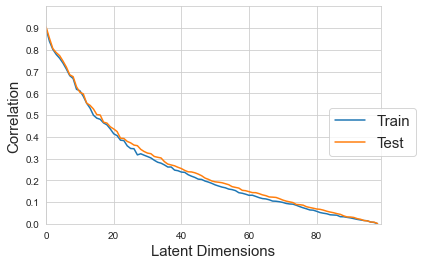

In [49]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()
sns.set_style('whitegrid')
dfs = [dcca_corr,dcca_test_corr]
for df in dfs:
    sns.lineplot(x=x,y=df,ax=ax)
fig.legend(labels=['Train', 'Test'], loc='center right', fontsize=15)
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1)
plt.xlim(0, latent_dims)
plt.yticks(np.arange(0, 1, step=0.1))
plt.show()

In [175]:
#score test dataset
# check the validation loop warning

In [78]:
v1_train.shape

(11200, 200)